In [11]:
import re
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
from textblob import TextBlob
from bertopic import BERTopic
import matplotlib.pyplot as plt
from transformers import pipeline

In [2]:
all_tweets_to_analyze_with_fx = pd.read_csv('all_tweets_to_analyze_with_fx_20250528_2244.csv')

In [3]:
all_tweets_to_analyze_with_fx.head()

,politician,date,tweet_text,sentiment_score,subjectivity_score,fear_score,economic_term_count,policy_term_count,currency_mention,economic_term_ratio,named_entities,topic_id,sentiment_volatility_7d,usd_try_ratio,euro_usd_ratio,xau_usd_ratio,sp500_value
0,Trump,2019-01-01 00:40:26,MEXICO IS PAYING FOR THE WALL through the many...,0.693526,0.555303,0.0,2,0,0,0.039216,"['MEXICO', 'U.S.A.', 'USMCA', 'NAFTA Trade Dea...",0,NaN,5.2869,1.14616,1281.31,2485.76
1,Trump,2019-01-01 00:51:43,"The Democrats will probably submit a Bill, bei...",-0.889143,1.000000,0.0,0,0,0,0.000000,"['Border Security', 'Tech']",0,1.119116,5.2869,1.14616,1281.31,2485.76
2,Trump,2019-01-01 01:05:39,...Remember this. Throughout the ages some thi...,-0.970347,0.433333,0.0,0,0,0,0.000000,"['NEVER', 'NEVER', 'ALWAYS', 'ALWAYS', 'NEVER']",0,0.938075,5.2869,1.14616,1281.31,2485.76
3,Trump,2019-01-01 12:51:34,"Dr. Sebastian Gorka, a very good and talented ...",0.992894,0.676909,0.0,0,0,0,0.000000,[],66,1.031419,5.2869,1.14616,1281.31,2485.76
4,Trump,2019-01-01 13:08:29,"HAPPY NEW YEAR TO EVERYONE, INCLUDING THE HATE...",0.967558,0.705429,0.0,0,0,0,0.000000,"['TRUMP DERANGEMENT SYNDROME', 'ENJOY']",139,1.001111,5.2869,1.14616,1281.31,2485.76


In [4]:
all_tweets_to_analyze_with_fx.shape

(13923, 17)

In [6]:
all_tweets_to_analyze_with_fx.columns

Index(['politician', 'date', 'tweet_text', 'sentiment_score',
       'subjectivity_score', 'fear_score', 'economic_term_count',
       'policy_term_count', 'currency_mention', 'economic_term_ratio',
       'named_entities', 'topic_id', 'sentiment_volatility_7d',
       'usd_try_ratio', 'euro_usd_ratio', 'xau_usd_ratio', 'sp500_value'],
      dtype='object')

In [7]:
all_tweets_to_analyze_with_fx.dtypes

politician                  object
date                        object
tweet_text                  object
sentiment_score            float64
subjectivity_score         float64
fear_score                 float64
economic_term_count          int64
policy_term_count            int64
currency_mention             int64
economic_term_ratio        float64
named_entities              object
topic_id                     int64
sentiment_volatility_7d    float64
usd_try_ratio              float64
euro_usd_ratio             float64
xau_usd_ratio              float64
sp500_value                float64
dtype: object

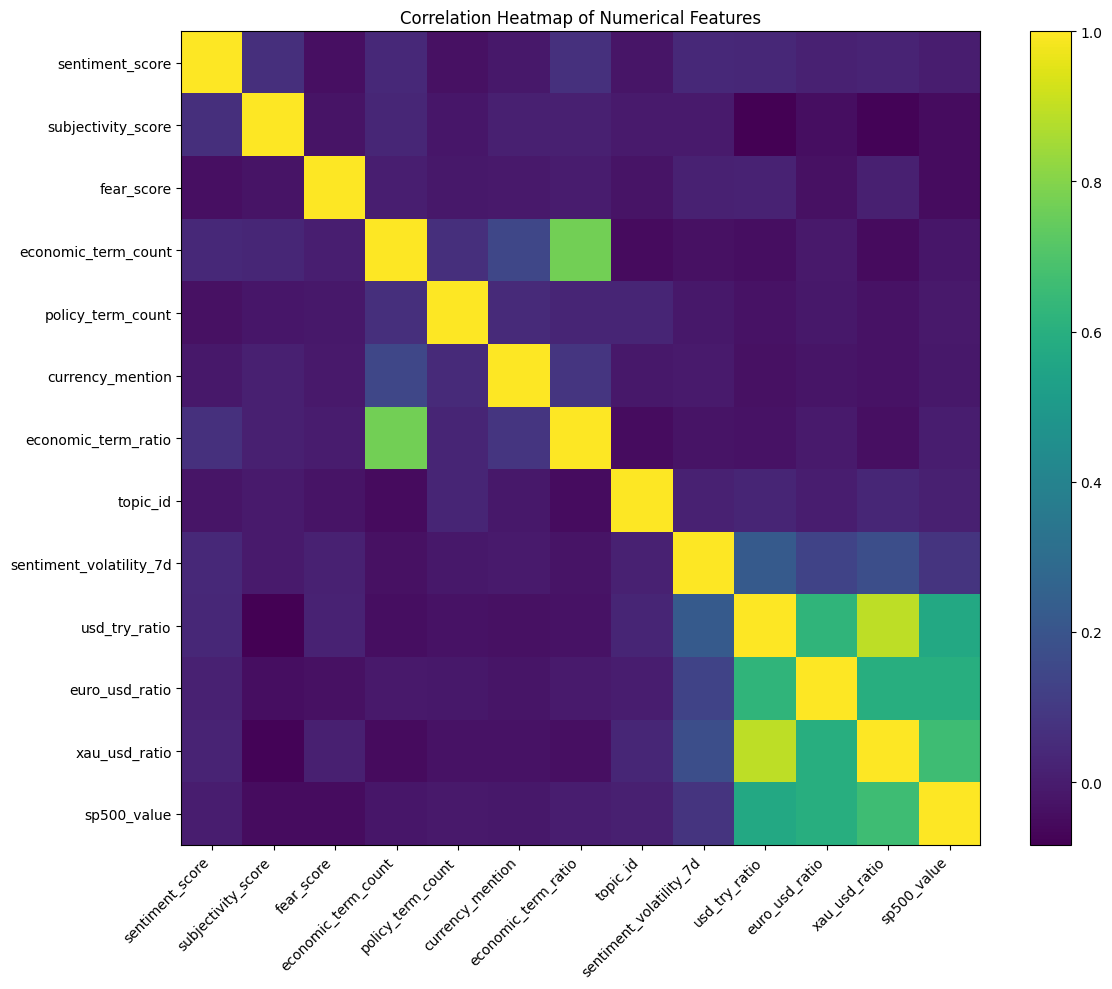

In [9]:
# Assume 'all_tweets_to_analyze_with_fx' is already available in the environment
df = all_tweets_to_analyze_with_fx.copy()

# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Select numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number])
corr = numeric_cols.corr()

# Plot the heatmap using matplotlib
plt.figure(figsize=(12, 10))
plt.imshow(corr.values, aspect='auto')
plt.colorbar()
plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(corr.index)), corr.index)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


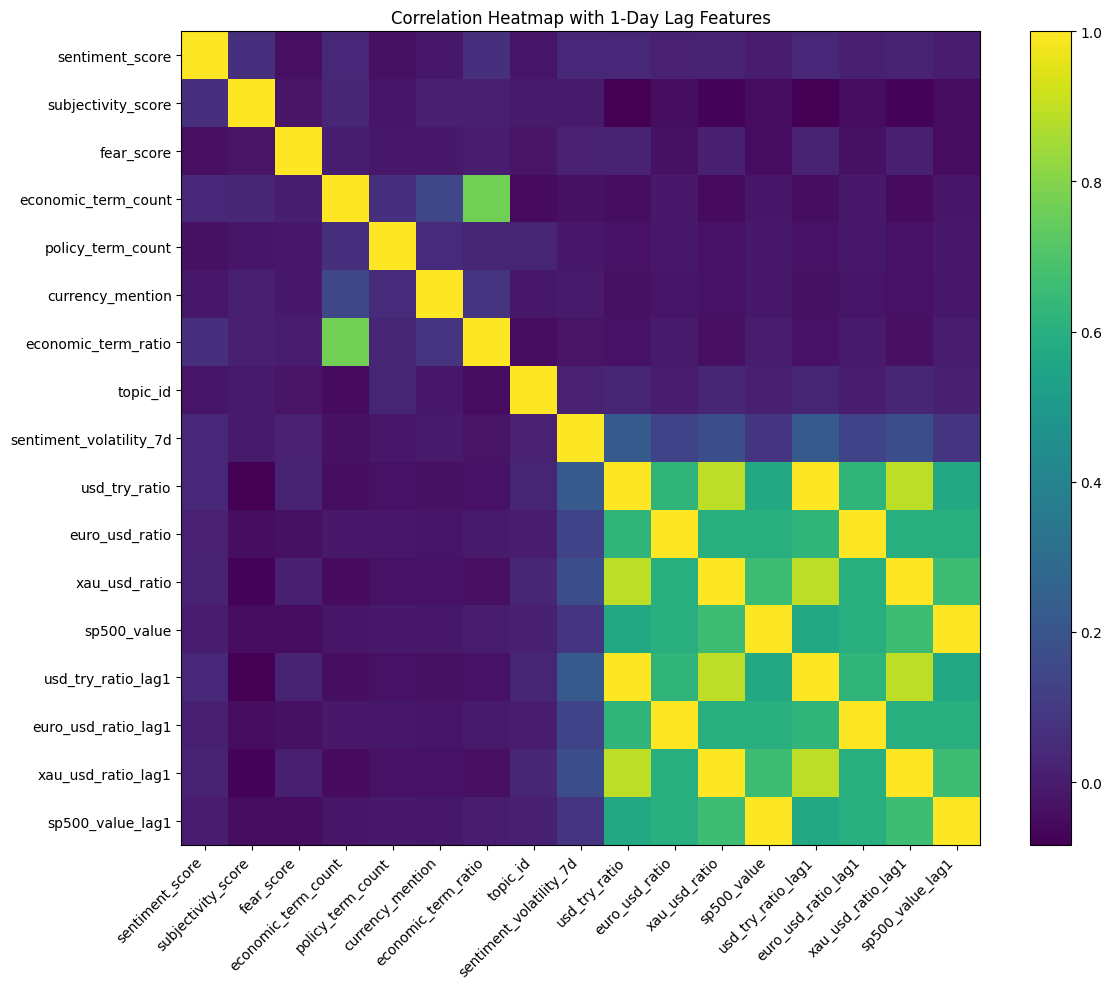

In [10]:
# Copy and prepare DataFrame
df = all_tweets_to_analyze_with_fx.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Create 1-day lag columns for market variables
df['usd_try_ratio_lag1']   = df['usd_try_ratio'].shift(1)
df['euro_usd_ratio_lag1']  = df['euro_usd_ratio'].shift(1)
df['xau_usd_ratio_lag1']   = df['xau_usd_ratio'].shift(1)
df['sp500_value_lag1']     = df['sp500_value'].shift(1)

# Drop the first row (which will have NaNs in the lag columns)
df = df.iloc[1:]

# Compute correlations including lagged features
numeric = df.select_dtypes(include=[np.number])
corr = numeric.corr()

# Plot updated heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr.values, aspect='auto')
plt.colorbar()
plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(corr.index)), corr.index)
plt.title('Correlation Heatmap with 1-Day Lag Features')
plt.tight_layout()
plt.show()

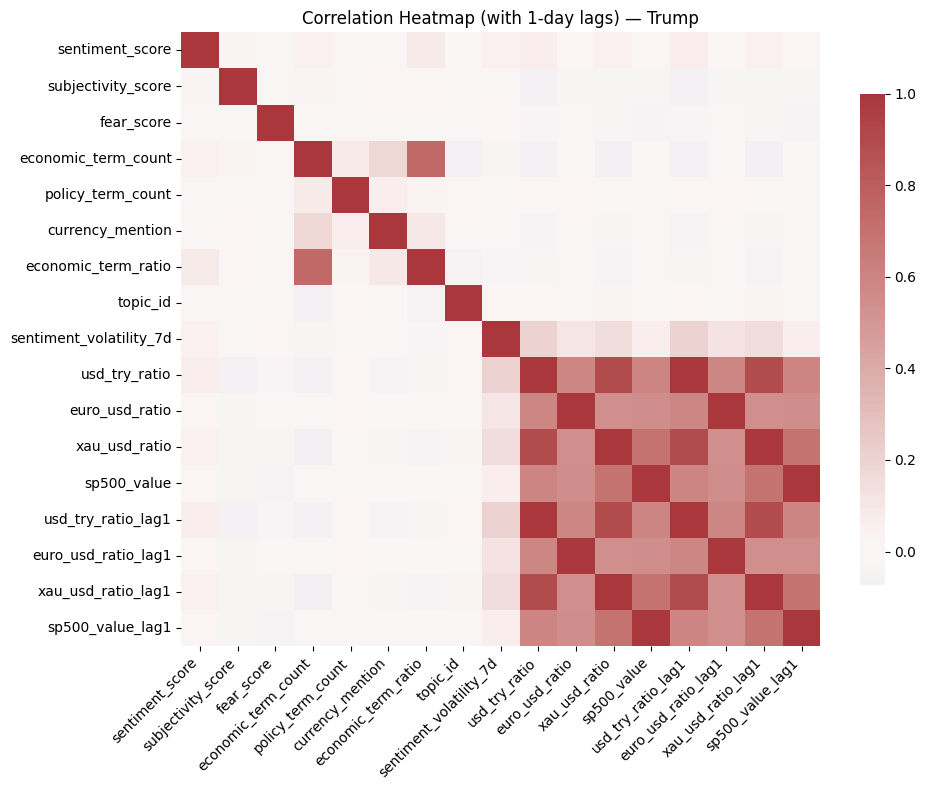

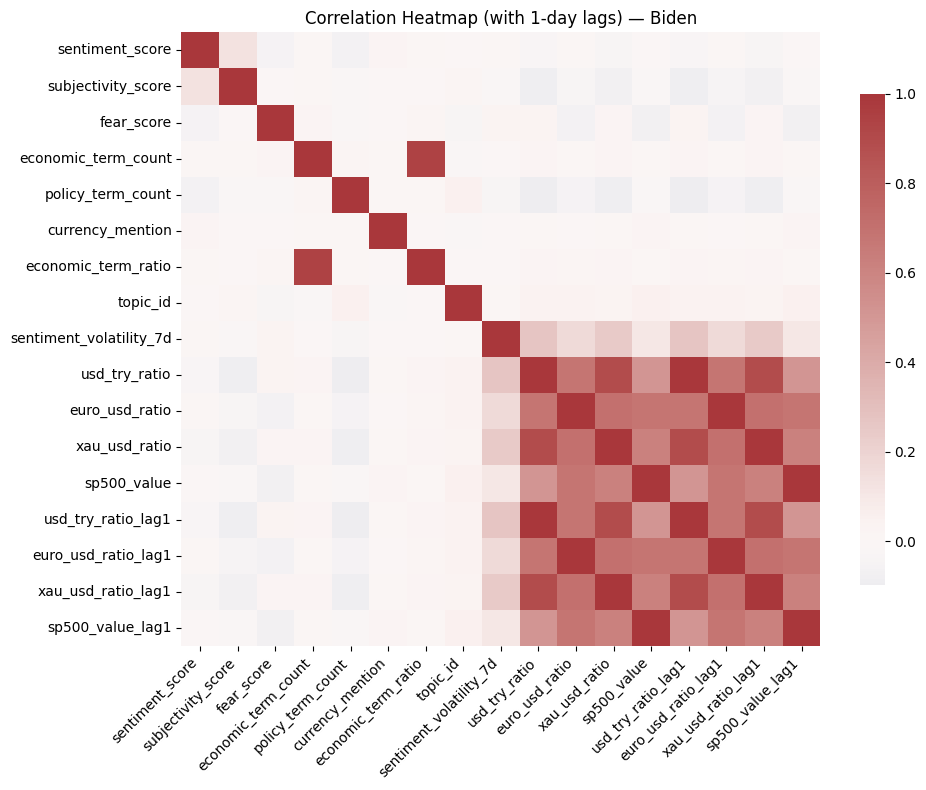

In [12]:
# 1) Prepare your DataFrame
df = all_tweets_to_analyze_with_fx.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Create 1-day lag columns
for col in ['usd_try_ratio','euro_usd_ratio','xau_usd_ratio','sp500_value']:
    df[f'{col}_lag1'] = df[col].shift(1)
df = df.dropna(subset=[f'{c}_lag1' for c in ['usd_try_ratio','euro_usd_ratio','xau_usd_ratio','sp500_value']])

# 2) Loop over each politician
for pol in df['politician'].unique():
    sub = df[df['politician']==pol]
    
    # select only numeric columns
    num = sub.select_dtypes(include=[np.number])
    
    # compute correlation matrix
    corr = num.corr()
    
    # 3) Plot
    plt.figure(figsize=(10,8))
    sns.heatmap(
        corr,
        cmap='vlag',
        center=0,
        annot=False,      # set True if you want the r-values annotated
        cbar_kws={'shrink':.8}
    )
    plt.title(f'Correlation Heatmap (with 1-day lags) — {pol}')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [14]:
df.head()

,politician,date,tweet_text,sentiment_score,subjectivity_score,fear_score,economic_term_count,policy_term_count,currency_mention,economic_term_ratio,...,topic_id,sentiment_volatility_7d,usd_try_ratio,euro_usd_ratio,xau_usd_ratio,sp500_value,usd_try_ratio_lag1,euro_usd_ratio_lag1,xau_usd_ratio_lag1,sp500_value_lag1
1,Trump,2019-01-01 00:51:43,"The Democrats will probably submit a Bill, bei...",-0.889143,1.000000,0.0,0,0,0,0.0,...,0,1.119116,5.2869,1.14616,1281.31,2485.76,5.2869,1.14616,1281.31,2485.76
2,Trump,2019-01-01 01:05:39,...Remember this. Throughout the ages some thi...,-0.970347,0.433333,0.0,0,0,0,0.0,...,0,0.938075,5.2869,1.14616,1281.31,2485.76,5.2869,1.14616,1281.31,2485.76
3,Trump,2019-01-01 12:51:34,"Dr. Sebastian Gorka, a very good and talented ...",0.992894,0.676909,0.0,0,0,0,0.0,...,66,1.031419,5.2869,1.14616,1281.31,2485.76,5.2869,1.14616,1281.31,2485.76
4,Trump,2019-01-01 13:08:29,"HAPPY NEW YEAR TO EVERYONE, INCLUDING THE HATE...",0.967558,0.705429,0.0,0,0,0,0.0,...,139,1.001111,5.2869,1.14616,1281.31,2485.76,5.2869,1.14616,1281.31,2485.76
5,Trump,2019-01-01 14:25:32,Happy New Year!,0.992498,0.727273,0.0,0,0,0,0.0,...,139,0.957911,5.2869,1.14616,1281.31,2485.76,5.2869,1.14616,1281.31,2485.76
